# Gamma Ray Bursts

Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
- You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. Be creative! You're discovering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(data)
print(data.shape)
print(names)

[['GRB240817A' 'GRB240814C' 'GRB240814B*' ... 'GRB910424A*' 'GRB910423A*'
  'GRB910421A*']
 ['GRB240817057' 'GRB240814785' 'GRB240814483' ... 'None' 'None' 'None']
 ['1:22:06.917' '18:50:17' '11:34:54.680' ... '19:43:25.064'
  '19:51:15.804' '9:14:03.800']
 ...
 ['1.7280' '69.0400' '12.0320' ... '3.1360' '208.5760' '5.6960']
 ['True' 'True' 'True' ... 'False' 'False' 'False']
 ['60539.05702450' '60536.78491898' '60536.48257731' ... '48370.82181787'
  '48369.82726625' '48367.38476620']]
(15, 8511)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']



## Data exploration

Let's have a look at the data:

In [3]:
ra = np.array(data[3], dtype=float)
decl = np.array(data[4], dtype=float)
t90_prov = np.array(data[6], dtype=float)
t90_err_prov = np.array(data[7], dtype=float)
fluence_prov = np.array(data[9], dtype=float)
fluence_err_prov = np.array(data[10], dtype=float)
z_prov = np.array(data[11], dtype=float)

t90_mask = t90_prov > 0
t90 = t90_prov[t90_mask]
t90_err = t90_err_prov[t90_mask]

fluence_mask = fluence_prov > 0
fluence = fluence_prov[fluence_mask]
fluence_err = fluence_err_prov[fluence_mask]

z_mask = z_prov > 0
z = z_prov[z_mask]

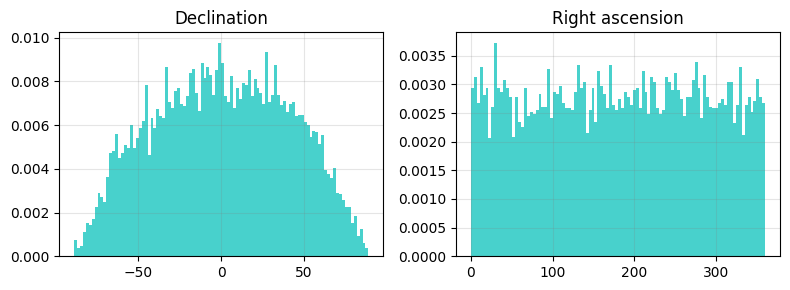

In [4]:
# Declination and right ascension
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].hist(decl, bins=100, density=True, color='mediumturquoise')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_title('Declination')

ax[1].hist(ra, bins=100, density=True, color='mediumturquoise')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_title('Right ascension')

plt.tight_layout()
plt.show()

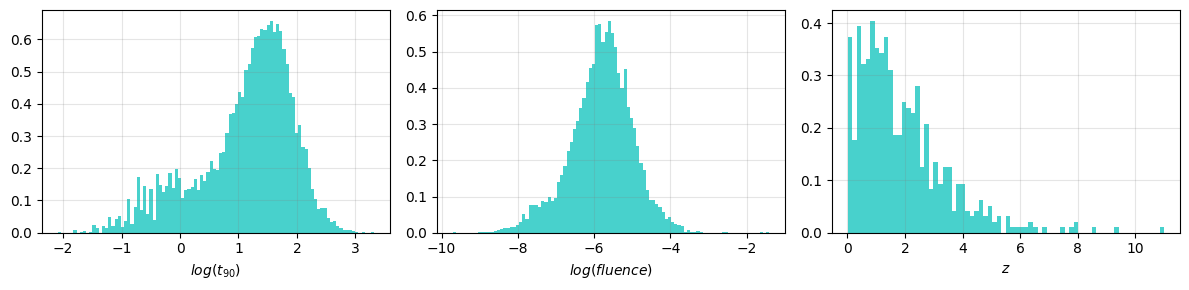

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

logt90 = np.log10(t90)
logfluence = np.log10(fluence)

ax[0].hist(logt90, bins=100, density=True, color='mediumturquoise')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('$log(t_{90})$')

ax[1].hist(logfluence, bins=100, density=True, color='mediumturquoise')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('$log(fluence)$')

ax[2].hist(z, bins=70, density=True, color='mediumturquoise')
ax[2].grid(c='grey', alpha = 0.2)
ax[2].set_xlabel('$z$')

plt.tight_layout()
plt.show()

There seems to be a bimodality in the $log(t_{90})$ distribution. Let's start from it.

## $t_{90}$


In [6]:
print(t90_prov.shape)
print(t90.shape)

(8511,)
(7431,)


We can start by fitting a KDE to the data:

### KDE


In [7]:
def kde_sklearn(data, bandwidth, kernel, xgrid):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(np.log10(xgrid)[:, np.newaxis])

    return np.exp(log_pdf)

In [8]:
bwrange = np.linspace(0.01,0.2, 10) # Testing 10 bandwidths from 0.01 to 0.2 with a 5-fold cross validation
print(bwrange)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= kf) 
grid.fit(logt90[:, np.newaxis])
band_opt_t90 = grid.best_params_['bandwidth']
print('Optimal bandwidth: %.2f' % band_opt_t90)

[0.01       0.03111111 0.05222222 0.07333333 0.09444444 0.11555556
 0.13666667 0.15777778 0.17888889 0.2       ]
Optimal bandwidth: 0.12


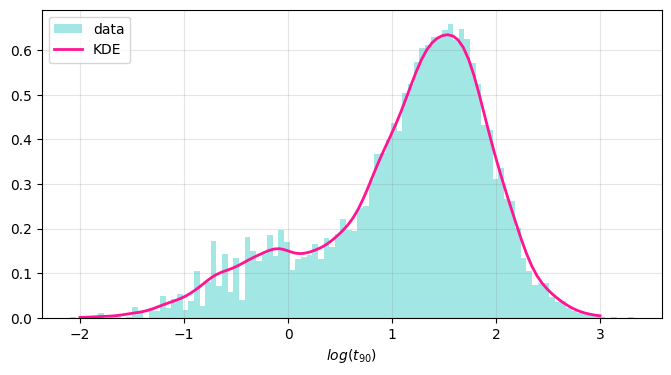

In [9]:
xgrid=np.logspace(-2,3,100)

plt.figure(figsize=(8, 4))
pdf = kde_sklearn(logt90, bandwidth = band_opt_t90, kernel='gaussian', xgrid=xgrid)
plt.hist(logt90, bins=100, density=True, color='mediumturquoise', alpha = 0.5, label = 'data')
plt.plot(np.log10(xgrid), pdf, c='deeppink', lw= 2, label = 'KDE')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.legend(loc='upper left')
plt.show()

This KDE confirms that the distribution is (at least) bimodal. We can also check with a gaussian mixture to search for the number of gaussians that best represents the data.

### Gaussian Mixture

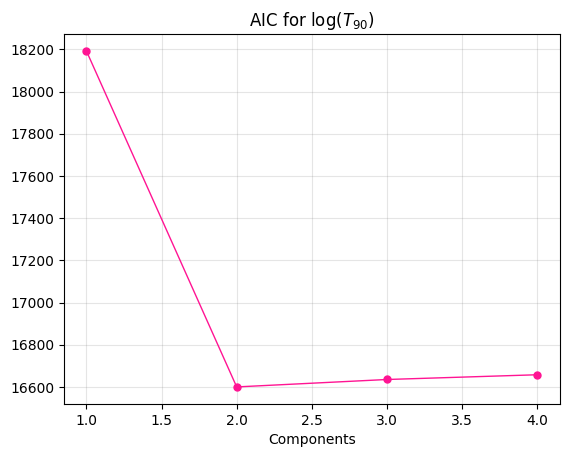

Optimal number of components according to AIC: 2
Optimal number of components through cross validation: 2


In [10]:
components = np.array([1, 2, 3, 4])     # I don't think there are more than 4 components

# Using AIC
gm = np.array([GaussianMixture(n_components=n).fit(logt90[:,np.newaxis]) for n in components])
AIC = np.empty(len(components))

for i, n in enumerate(components):
    AIC[i] = gm[i].aic(logt90[:, np.newaxis])

plt.plot(components, AIC, c = 'deeppink', markersize = 5, marker = 'o', linewidth = 1)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('Components')
plt.title('AIC for log($T_{90}$)')
plt.show()

print('Optimal number of components according to AIC: %i' % components[np.argmin(AIC)]) 
best_model_t90 = gm[np.argmin(AIC)]

# Using cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': components}, cv= kf) 
grid.fit(logt90[:, np.newaxis])
n_opt_t90 = grid.best_params_['n_components']
print('Optimal number of components through cross validation: %i' % n_opt_t90)

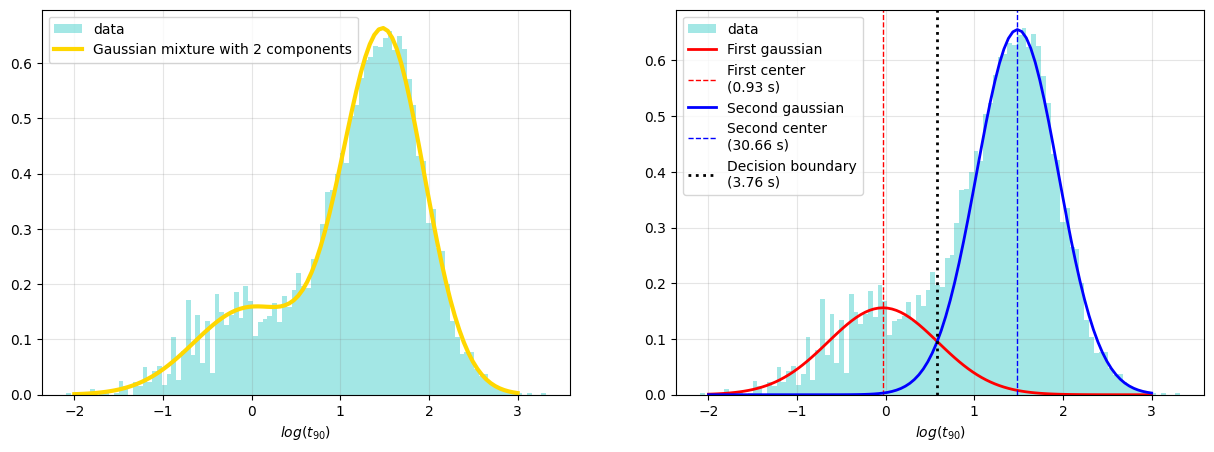

In [11]:
xgrid=np.linspace(-2, 3, 100)

# Plotting the Gaussian mixture model
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(logt90, bins=100, density=True, color='mediumturquoise', alpha=0.5, label = 'data')
ax[0].plot(xgrid, np.exp(best_model_t90.score_samples(xgrid[:, np.newaxis])), c='gold', lw= 3, label = 'Gaussian mixture with 2 components')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('$log(t_{90})$')
ax[0].legend(loc='upper left')

# Plotting the single gaussians
means = best_model_t90.means_.flatten()
order_gmm_t90 = np.argsort(means)
means_t90 = means[order_gmm_t90]
contr_t90 = best_model_t90.predict_proba(xgrid[:, np.newaxis])[:, order_gmm_t90]
pdf_contr_t90 = contr_t90*np.exp(best_model_t90.score_samples(xgrid[:, np.newaxis]))[:, np.newaxis]
decision_boundary_gmm_t90 = xgrid[np.argmin(np.abs(contr_t90[:, 0] - contr_t90[:, 1]))]

ax[1].hist(logt90, bins=100, density=True, color='mediumturquoise', alpha = 0.5, label = 'data')
ax[1].plot(xgrid, pdf_contr_t90[:, 0], c='red', lw= 2, label = 'First gaussian')
ax[1].axvline(means_t90[0], c='red', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % 10**means_t90[0])
ax[1].plot(xgrid, pdf_contr_t90[:, 1], c='blue', lw= 2, label = 'Second gaussian')
ax[1].axvline(means_t90[1], c='blue', lw = 1, ls = '--', label = 'Second center\n(%.2f s)' % 10**means_t90[1])
ax[1].axvline(decision_boundary_gmm_t90, c='black', lw = 2, ls = ':', label = 'Decision boundary\n(%.2f s)' % 10**decision_boundary_gmm_t90)
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('$log(t_{90})$')
ax[1].legend(loc='upper left')
plt.show()

We can now be fairly confident about the bimodality of the data. That's what we expected: we know GRB are divided in long and short, so two clusters are a good result. Let's use K-means clustering to find the centers of the clusters and the decision boundary.

### K-Means clustering

In [12]:
scaler = preprocessing.StandardScaler()
scaled_logt90 = scaler.fit_transform(logt90[:, np.newaxis])

In [13]:
km_t90 = KMeans(n_clusters=2)
km_t90.fit(scaled_logt90)

scaled_centers_km_t90 = km_t90.cluster_centers_
labels_km_t90 = km_t90.predict(scaled_logt90)

if scaled_centers_km_t90[0] > scaled_centers_km_t90[1]:
    scaled_centers_km_t90 = scaled_centers_km_t90[::-1]
    labels_km_t90 = np.array(~np.array(labels_km_t90, dtype='bool'), dtype='int')

centers_km_t90 = scaler.inverse_transform(scaled_centers_km_t90)

decision_boundary_km_t90 = np.mean([max(logt90[labels_km_t90==0]), min(logt90[labels_km_t90==1])])

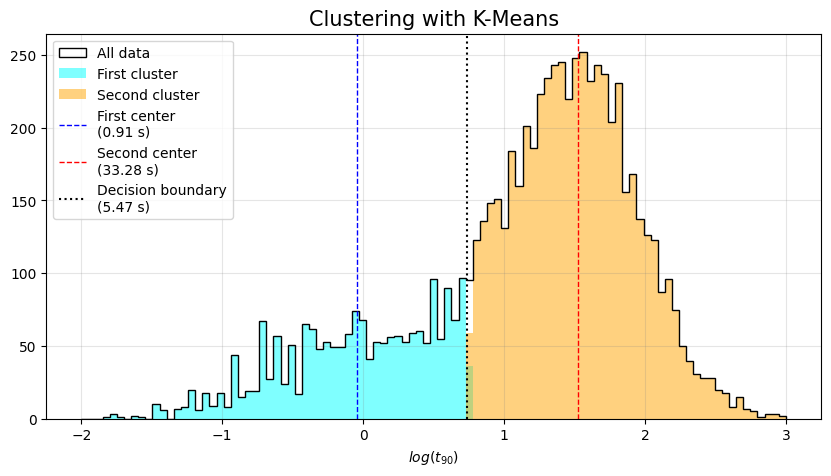

In [14]:
plt.figure(figsize=(10, 5))
plt.hist(logt90, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
plt.hist(logt90[labels_km_t90==0], bins=np.linspace(-2, 3, 100), color='cyan', alpha = 0.5, label = 'First cluster')
plt.hist(logt90[labels_km_t90==1], bins=np.linspace(-2, 3, 100), color='orange', alpha = 0.5, label = 'Second cluster') 
plt.axvline(centers_km_t90[0], c = 'blue', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % 10**centers_km_t90[0][0])
plt.axvline(centers_km_t90[1], c = 'red', lw = 1, ls = '--', label = 'Second center\n(%.2f s)' % 10**centers_km_t90[1][0])
plt.axvline(decision_boundary_km_t90, c = 'black', lw = 1.5, ls = ':', label = 'Decision boundary\n(%.2f s)' % 10**decision_boundary_km_t90)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.title('Clustering with K-Means', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

### MeanShift clustering

In [15]:
bandwidth_ms_t90 = estimate_bandwidth(logt90[:, np.newaxis])
ms_t90 = MeanShift(bandwidth=bandwidth_ms_t90)
print('Estimated bandwidth: %.2f' % bandwidth_ms_t90)
ms_t90.fit(scaled_logt90)

Estimated bandwidth: 0.52


MeanShift(bandwidth=0.5191184471769927)

In [16]:
labels_ms_t90 = ms_t90.labels_
labels_unique_ms_t90 = np.unique(ms_t90.labels_)
print(labels_unique_ms_t90)

n_clusters_ms_t90 = len(labels_unique_ms_t90)
print("Number of estimated clusters : %i" % n_clusters_ms_t90)

scaled_centers_ms_t90 = ms_t90.cluster_centers_

if scaled_centers_ms_t90[0] > scaled_centers_ms_t90[1]:
    scaled_centers_ms_t90 = scaled_centers_ms_t90[::-1]
    labels_ms_t90 = np.array(~np.array(labels_ms_t90, dtype='bool'), dtype='int')

centers_ms_t90 = scaler.inverse_transform(scaled_centers_ms_t90)

decision_boundary_ms_t90 = np.mean([max(logt90[labels_ms_t90==0]), min(logt90[labels_ms_t90==1])])

[0 1]
Number of estimated clusters : 2


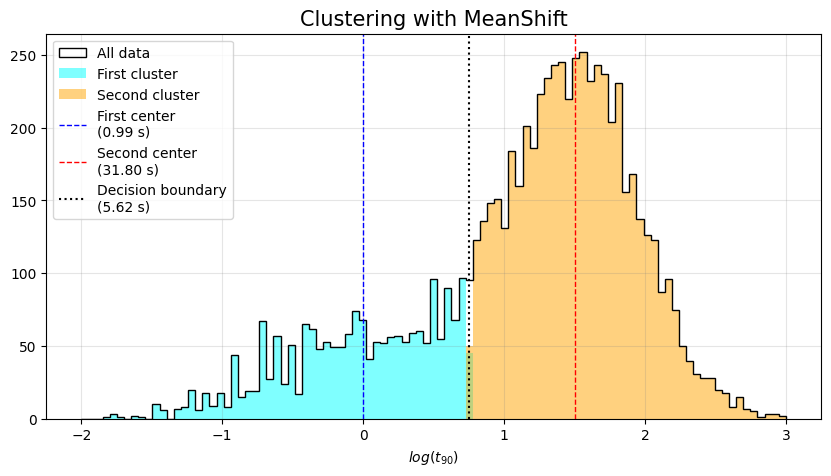

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(logt90, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
plt.hist(logt90[labels_ms_t90==0], bins=np.linspace(-2, 3, 100), color='cyan', alpha = 0.5, label = 'First cluster')
plt.hist(logt90[labels_ms_t90==1], bins=np.linspace(-2, 3, 100), color='orange', alpha = 0.5, label = 'Second cluster') 
plt.axvline(centers_ms_t90[0], c = 'blue', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % 10**centers_ms_t90[0][0])
plt.axvline(centers_ms_t90[1], c = 'red', lw = 1, ls = '--', label = 'Second center\n(%.2f s)' % 10**centers_ms_t90[1][0])
plt.axvline(decision_boundary_ms_t90, c = 'black', lw = 1.5, ls = ':', label = 'Decision boundary\n(%.2f s)' % 10**decision_boundary_ms_t90)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.title('Clustering with MeanShift', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

MeanShift, too, agrees about the presence of two clusters.

Let's display the summary of results:

In [18]:
print('METHOD\t\tCLUSTER CENTERS\t\tDECISION BOUNDARY')
print('GMM\t\t%.2f  -  %.2f\t\t%.2f' % (10**means_t90[0], 10**means_t90[1], 10**decision_boundary_gmm_t90))
print('K-Means\t\t%.2f  -  %.2f\t\t%.2f' % (10**centers_km_t90[0][0], 10**centers_km_t90[1][0], 10**decision_boundary_km_t90))
print('MeanShift\t%.2f  -  %.2f\t\t%.2f' % (10**centers_ms_t90[0][0], 10**centers_ms_t90[1][0], 10**decision_boundary_ms_t90))

METHOD		CLUSTER CENTERS		DECISION BOUNDARY
GMM		0.93  -  30.66		3.76
K-Means		0.91  -  33.28		5.47
MeanShift	0.99  -  31.80		5.62


So, all three methods yield similar results. In the GMM case, though, the decision boundary is lower.

## Fluence

We can repeat the same analysis for the fluence - where there might be a bimodal distribution, but it's not so evident. 

### KDE

In [19]:
bwrange = np.linspace(0.01, 0.2, 10)
print(bwrange)

n_splits = 20
kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= kf) 
grid.fit(logfluence[:, np.newaxis])
band_opt_fl = grid.best_params_['bandwidth']
print('Optimal bandwidth: %.2f' % band_opt_fl)

[0.01       0.03111111 0.05222222 0.07333333 0.09444444 0.11555556
 0.13666667 0.15777778 0.17888889 0.2       ]
Optimal bandwidth: 0.16


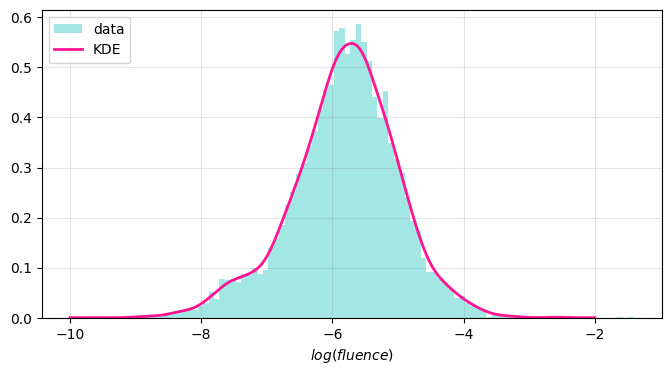

In [20]:
xgrid=np.logspace(-10,-2,500)

plt.figure(figsize=(8, 4))
pdf = kde_sklearn(logfluence, bandwidth = band_opt_fl, kernel='gaussian', xgrid=xgrid)
plt.hist(logfluence, bins=100, density=True, color='mediumturquoise', alpha = 0.5, label = 'data')
plt.plot(np.log10(xgrid), pdf, c='deeppink', lw= 2, label = 'KDE')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(fluence)$')
plt.legend(loc='upper left')
plt.show()

So, there might be a bimodality here, too!

### Gaussian mixture

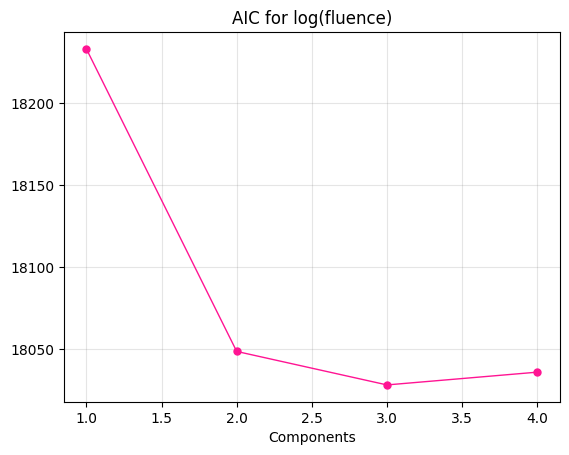

Optimal number of components according to AIC: 3
Optimal number of components through cross validation: 3


In [21]:
components = np.array([1, 2, 3, 4])

# Using AIC
gm = np.array([GaussianMixture(n_components=n).fit(logfluence[:,np.newaxis]) for n in components])
AIC = np.empty(len(components))

for i, n in enumerate(components):
    AIC[i] = gm[i].aic(logfluence[:, np.newaxis])

plt.plot(components, AIC, c = 'deeppink', markersize = 5, marker = 'o', linewidth = 1)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('Components')
plt.title('AIC for log(fluence)')
plt.show()

print('Optimal number of components according to AIC: %i' % components[np.argmin(AIC)]) 
best_model_fl = gm[np.argmin(AIC)]

# Using cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': components}, cv= kf) 
grid.fit(logfluence[:, np.newaxis])
n_opt_fl = grid.best_params_['n_components']
print('Optimal number of components through cross validation: %i' % n_opt_fl)

Well, that's a surprise. 

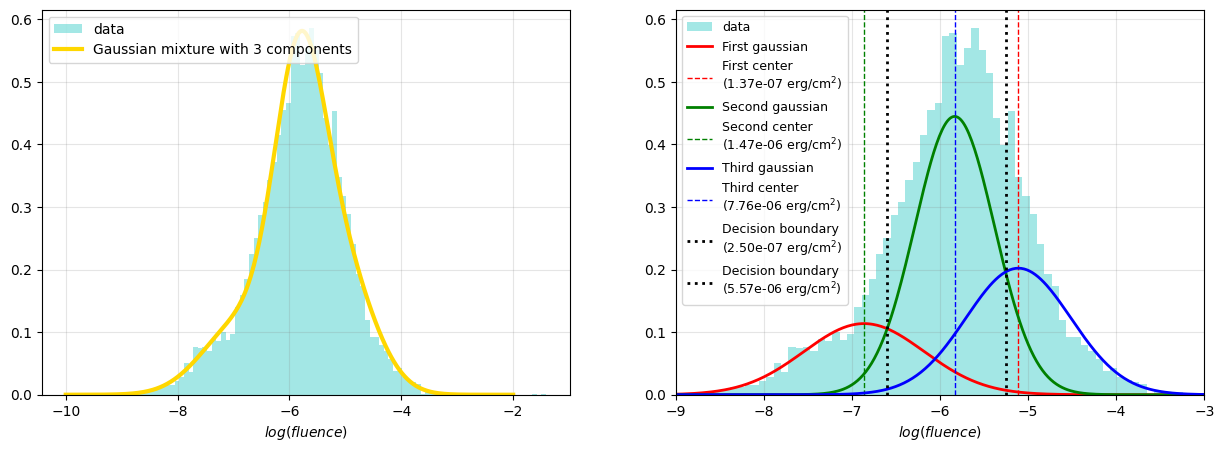

In [22]:
xgrid=np.linspace(-10, -2, 500)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(logfluence, bins=100, density=True, color='mediumturquoise', alpha=0.5, label = 'data')
ax[0].plot(xgrid, np.exp(best_model_fl.score_samples(xgrid[:, np.newaxis])), c='gold', lw= 3, label = 'Gaussian mixture with 3 components')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('$log(fluence)$')
ax[0].legend(loc='upper left')

# Plotting the single gaussians
means = best_model_fl.means_.flatten()
order_gmm_fl = np.argsort(means)
means_fl = means[order_gmm_fl]
contr_fl = best_model_fl.predict_proba(xgrid[:, np.newaxis])[:, order_gmm_fl]
pdf_contr_fl = contr_fl*np.exp(best_model_fl.score_samples(xgrid[:, np.newaxis]))[:, np.newaxis]

# For the decision boundaries, I have to make sure they fall in between the gaussians, or they will be plotted in the
# "external" intersections (in the left tails for 1 and 2, and in the right tails for 2 and 3).

def find_decision_boundary(xgrid, contr1, contr2, mean1, mean2):
    mask = (xgrid > mean1) & (xgrid < mean2)
    return xgrid[mask][np.argmin(np.abs(contr1[mask] - contr2[mask]))]

decision_boundary_gmm_12_fl = find_decision_boundary(xgrid, contr_fl[:, 0], contr_fl[:, 1], means_fl[0], means_fl[1])
decision_boundary_gmm_23_fl = find_decision_boundary(xgrid, contr_fl[:, 1], contr_fl[:, 2], means_fl[1], means_fl[2])

ax[1].hist(logfluence, bins=100, density=True, color='mediumturquoise', alpha = 0.5, label = 'data')
ax[1].plot(xgrid, pdf_contr_fl[:, 0], c='red', lw= 2, label = 'First gaussian')
ax[1].axvline(means[0], c='red', lw = 1, ls = '--', label = 'First center\n(%.2e erg/cm$^2$)' % 10**means_fl[0])
ax[1].plot(xgrid, pdf_contr_fl[:, 1], c='green', lw= 2, label = 'Second gaussian')
ax[1].axvline(means[1], c='green', lw = 1, ls = '--', label = 'Second center\n(%.2e erg/cm$^2$)' % 10**means_fl[1])
ax[1].plot(xgrid, pdf_contr_fl[:, 2], c='blue', lw= 2, label = 'Third gaussian')
ax[1].axvline(means[2], c='blue', lw = 1, ls = '--', label = 'Third center\n(%.2e erg/cm$^2$)' % 10**means_fl[2])
ax[1].axvline(decision_boundary_gmm_12_fl, c='black', lw = 2, ls = ':', label = 'Decision boundary\n(%.2e erg/cm$^2$)' % 10**decision_boundary_gmm_12_fl)
ax[1].axvline(decision_boundary_gmm_23_fl, c='black', lw = 2, ls = ':', label = 'Decision boundary\n(%.2e erg/cm$^2$)' % 10**decision_boundary_gmm_23_fl)
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('$log(fluence)$')
ax[1].set_xlim((-9, -3))
ax[1].legend(loc='upper left', fontsize = 9)
plt.show()

I don't think this result makes much sense, and the Gaussian Mixture looks very similar to what I would expect a 2-components gmm to be. Let's see how 
this changes by forcing the model to have two components:

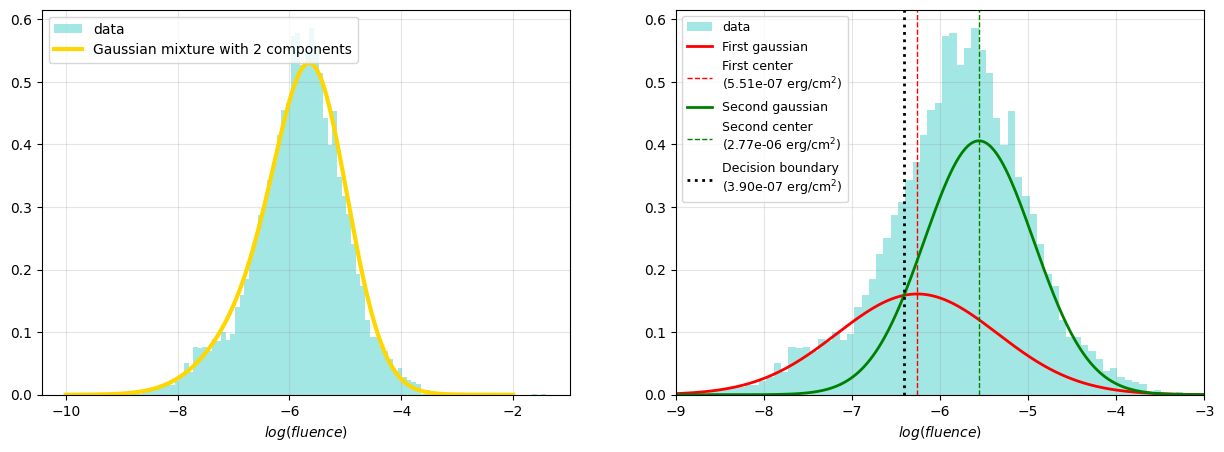

In [23]:
model_2_comps = GaussianMixture(n_components=2).fit(logfluence[:, np.newaxis])

xgrid=np.linspace(-10, -2, 500)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(logfluence, bins=100, density=True, color='mediumturquoise', alpha=0.5, label = 'data')
ax[0].plot(xgrid, np.exp(model_2_comps.score_samples(xgrid[:, np.newaxis])), c='gold', lw= 3, label = 'Gaussian mixture with 2 components')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('$log(fluence)$')
ax[0].legend(loc='upper left')

means = model_2_comps.means_.flatten()
order_gmm_fl_2 = np.argsort(means)
means_fl_2 = means[order_gmm_fl_2]
contr_fl_2 = model_2_comps.predict_proba(xgrid[:, np.newaxis])[:, order_gmm_fl_2]
pdf_contr_fl_2 = contr_fl_2*np.exp(model_2_comps.score_samples(xgrid[:, np.newaxis]))[:, np.newaxis]

# In this case, the function defined before has to be modified: the intersection falls before the first gaussian mean, but if I'm not forcing
# a restriction, the code finds it at the intersection of the right tails.
def find_decision_boundary_2(xgrid, contr1, contr2, mean1, mean2):
    mask = xgrid < mean2
    return xgrid[mask][np.argmin(np.abs(contr1[mask] - contr2[mask]))]
    
decision_boundary_gmm_12_fl_2 = find_decision_boundary_2(xgrid, contr_fl_2[:, 0], contr_fl_2[:, 1], means_fl_2[0], means_fl_2[1])

ax[1].hist(logfluence, bins=100, density=True, color='mediumturquoise', alpha = 0.5, label = 'data')
ax[1].plot(xgrid, pdf_contr_fl_2[:, 0], c='red', lw= 2, label = 'First gaussian')
ax[1].axvline(means[0], c='red', lw = 1, ls = '--', label = 'First center\n(%.2e erg/cm$^2$)' % 10**means_fl_2[0])
ax[1].plot(xgrid, pdf_contr_fl_2[:, 1], c='green', lw= 2, label = 'Second gaussian')
ax[1].axvline(means[1], c='green', lw = 1, ls = '--', label = 'Second center\n(%.2e erg/cm$^2$)' % 10**means_fl_2[1])
ax[1].axvline(decision_boundary_gmm_12_fl_2, c='black', lw = 2, ls = ':', label = 'Decision boundary\n(%.2e erg/cm$^2$)' % 10**decision_boundary_gmm_12_fl_2)
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('$log(fluence)$')
ax[1].set_xlim((-9, -3))
ax[1].legend(loc='upper left', fontsize = 9)
plt.show()

So, the results aren't much different, and since I expect to be a short GRB cluster and a long GRB one, I'm more interested in forcing this model. I expect the fluence of the short GRB to be smaller.

Let's see the results with K-means:

### K-means clustering

In [24]:
scaler = preprocessing.StandardScaler()
scaled_logfluence = scaler.fit_transform(logfluence[:, np.newaxis])

In [25]:
km_fl = KMeans(n_clusters=2)
km_fl.fit(scaled_logfluence)

scaled_centers_km_fl = km_fl.cluster_centers_
labels_km_fl = km_fl.predict(scaled_logfluence)

if scaled_centers_km_fl[0] > scaled_centers_km_fl[1]:
    scaled_centers_km_fl = scaled_centers_km_fl[::-1]
    labels_km_fl = np.array(~np.array(labels_km_fl, dtype='bool'), dtype='int')

centers_km_fl = scaler.inverse_transform(scaled_centers_km_fl)

decision_boundary_km_fl = np.mean([max(logfluence[labels_km_fl==0]), min(logfluence[labels_km_fl==1])])

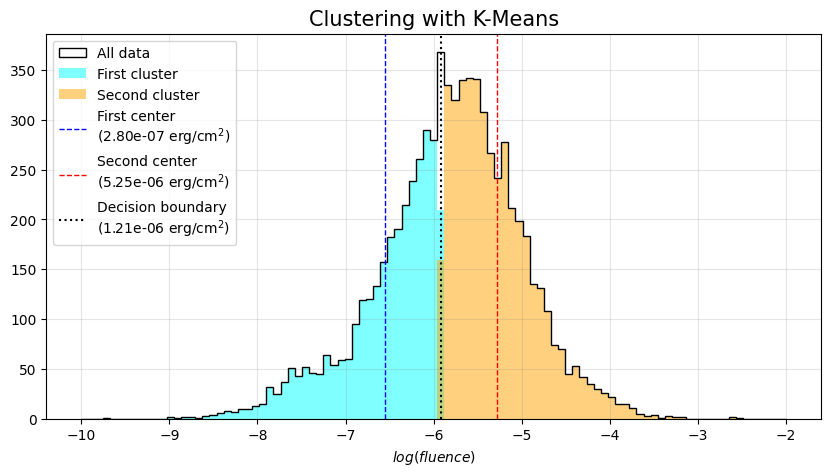

In [26]:
plt.figure(figsize=(10, 5))
plt.hist(logfluence, bins=np.linspace(-10, -2, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
plt.hist(logfluence[labels_km_fl==0], bins=np.linspace(-10, -2, 100), color='cyan', alpha = 0.5, label = 'First cluster')
plt.hist(logfluence[labels_km_fl==1], bins=np.linspace(-10, -2, 100), color='orange', alpha = 0.5, label = 'Second cluster') 
plt.axvline(centers_km_fl[0], c = 'blue', lw = 1, ls = '--', label = 'First center\n(%.2e erg/cm$^2$)' % 10**centers_km_fl[0][0])
plt.axvline(centers_km_fl[1], c = 'red', lw = 1, ls = '--', label = 'Second center\n(%.2e erg/cm$^2$)' % 10**centers_km_fl[1][0])
plt.axvline(decision_boundary_km_fl, c = 'black', lw = 1.5, ls = ':', label = 'Decision boundary\n(%.2e erg/cm$^2$)' % 10**decision_boundary_km_fl)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(fluence)$')
plt.title('Clustering with K-Means', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

Since the gmm already had problems in finding 2 clusters, I'm not sure I should trust the results of a MeanShift clustering, but let's try anyway.

### MeanShift Clustering

In [27]:
bandwidth_ms_fl = estimate_bandwidth(logfluence[:, np.newaxis])
ms_fl = MeanShift(bandwidth=bandwidth_ms_fl)
print('Estimated bandwidth: %.2f' % bandwidth_ms_fl)
ms_fl.fit(scaled_logfluence)

Estimated bandwidth: 0.52


MeanShift(bandwidth=0.5187091487981144)

In [28]:
labels_ms_fl = ms_fl.labels_
labels_unique_ms_fl = np.unique(ms_fl.labels_)
print(labels_unique_ms_fl)

n_clusters_ms_fl = len(labels_unique_ms_fl)
print("Number of estimated clusters : %i" % n_clusters_ms_fl)

scaled_centers_ms_fl = ms_fl.cluster_centers_
centers_ms_fl = scaler.inverse_transform(scaled_centers_ms_fl)

[0 1 2 3]
Number of estimated clusters : 4


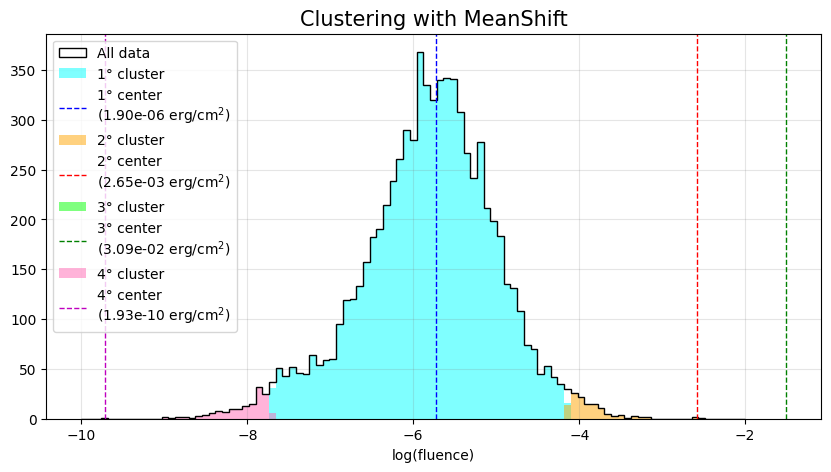

In [29]:
plt.figure(figsize=(10, 5))
plt.hist(logfluence, bins=np.linspace(-10, -2, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')

colors = ['cyan', 'orange', 'lime', 'hotpink']
colors_lines = ['blue', 'red', 'green', 'm']

for i in labels_unique_ms_fl:
    plt.hist(logfluence[labels_ms_fl==i], bins=np.linspace(-10, -2, 100), color=colors[i], alpha = 0.5, label = '%i° cluster' % (i+1))
    plt.axvline(centers_ms_fl[i], c = colors_lines[i], lw = 1, ls = '--', label = '%i° center\n(%.2e erg/cm$^2$)' % (i+1, 10**centers_ms_fl[i][0]))

plt.grid(c='grey', alpha = 0.2)
plt.xlabel('log(fluence)')
plt.title('Clustering with MeanShift', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

This result isn't so great, and one of the clusters isn't even visible. Let's see how many elements belong to it: 

In [30]:
for i in labels_unique_ms_fl:
    print('%i° cluster: %i elements' % (i+1, logfluence[labels_ms_fl == i].shape[0]))

1° cluster: 7228 elements
2° cluster: 126 elements
3° cluster: 2 elements
4° cluster: 148 elements


Let's try to force a better result with an increased bandwidth:

In [31]:
ms_fl_new = MeanShift(bandwidth=bandwidth_ms_fl*2)
ms_fl_new.fit(scaled_logfluence)

MeanShift(bandwidth=1.0374182975962287)

In [32]:
labels_ms_fl_new = ms_fl_new.labels_
labels_unique_ms_fl_new = np.unique(ms_fl_new.labels_)
print(labels_unique_ms_fl_new)

n_clusters_ms_fl_new = len(labels_unique_ms_fl_new)
print("Number of estimated clusters : %i" % n_clusters_ms_fl_new)

[0 1]
Number of estimated clusters : 2


This time, the number of clusters is the one we're searching for. Let's see the result:

In [33]:
scaled_centers_ms_fl_new = ms_fl_new.cluster_centers_

if scaled_centers_ms_fl_new[0] > scaled_centers_ms_fl_new[1]:
    scaled_centers_ms_fl_new = scaled_centers_ms_fl_new[::-1]
    labels_ms_fl_new = np.array(~np.array(labels_ms_fl_new, dtype='bool'), dtype='int')

centers_ms_fl_new = scaler.inverse_transform(scaled_centers_ms_fl_new)

decision_boundary_ms_fl_new = np.mean([max(logfluence[labels_ms_fl_new==0]), min(logfluence[labels_ms_fl_new==1])])

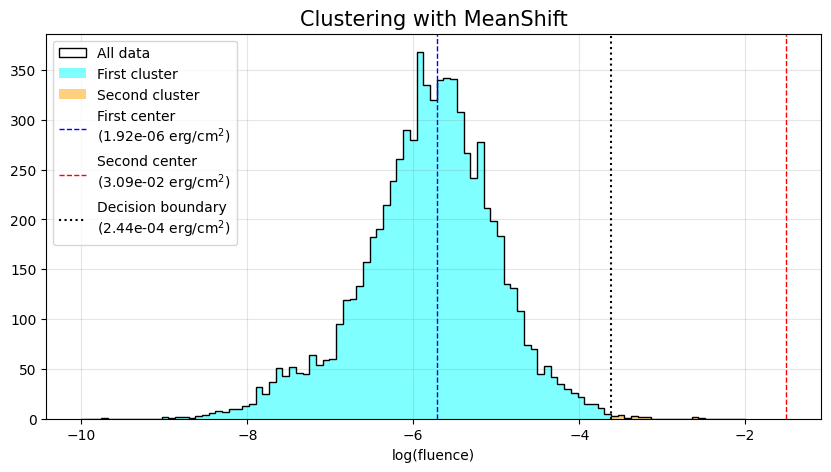

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(logfluence, bins=np.linspace(-10, -2, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
plt.hist(logfluence[labels_ms_fl_new==0], bins=np.linspace(-10, -2, 100), color='cyan', alpha = 0.5, label = 'First cluster')
plt.hist(logfluence[labels_ms_fl_new==1], bins=np.linspace(-10, -2, 100), color='orange', alpha = 0.5, label = 'Second cluster') 
plt.axvline(centers_ms_fl_new[0], c = 'blue', lw = 1, ls = '--', label = 'First center\n(%.2e erg/cm$^2$)' % 10**centers_ms_fl_new[0][0])
plt.axvline(centers_ms_fl_new[1], c = 'red', lw = 1, ls = '--', label = 'Second center\n(%.2e erg/cm$^2$)' % 10**centers_ms_fl_new[1][0])
plt.axvline(decision_boundary_ms_fl_new, c = 'black', lw = 1.5, ls = ':', label = 'Decision boundary\n(%.2e erg/cm$^2$)' % 10**decision_boundary_ms_fl_new)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('log(fluence)')
plt.title('Clustering with MeanShift', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

That's not good, either. Even if we were to filter out clusters with too little points, the majority of the data would still belong to a single cluster, and not the two we're searching for. This means that in the next step, we'll give more importance to the gaussian mixture analysis or the KMeans one.

Let's display the results for the fluence (minus the ones for the meanshift):

In [35]:
print('METHOD\t\tCLUSTER CENTERS\t\tDECISION BOUNDARY')
print('GMM\t\t%.2e  -  %.2e\t\t%.2e' % (10**means_fl_2[0], 10**means_fl_2[1], 10**decision_boundary_gmm_12_fl_2))
print('K-Means\t\t%.2e  -  %.2e\t\t%.2e' % (10**centers_km_fl[0][0], 10**centers_km_fl[1][0], 10**decision_boundary_km_fl))

METHOD		CLUSTER CENTERS		DECISION BOUNDARY
GMM		5.51e-07  -  2.77e-06		3.90e-07
K-Means		2.80e-07  -  5.25e-06		1.21e-06


## 2-D clustering

Now that we have an idea of the clusters in the single dimensions, let's see how it works in 2 dimensions.

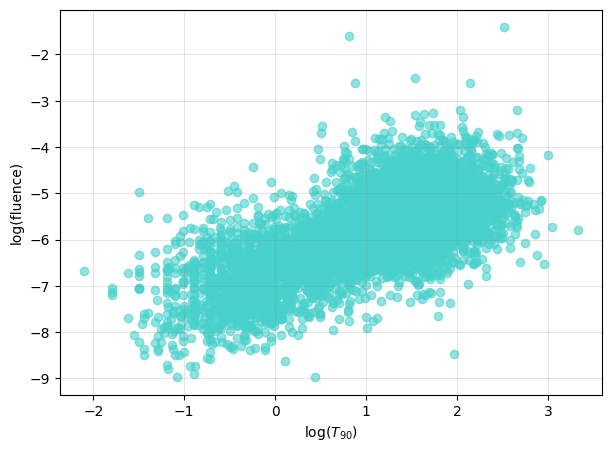

In [36]:
# I have to make sure that logt90 and logfluence have the same dimension
mask_2d = np.logical_and(t90_prov > 0, fluence_prov > 0)
new_logt90 = np.log10(t90_prov[mask_2d])
new_logfluence = np.log10(fluence_prov[mask_2d])

plt.figure(figsize = (7, 5))
plt.scatter(new_logt90, new_logfluence, c = 'mediumturquoise', alpha = 0.6)
plt.xlabel('log$(T_{90})$')
plt.ylabel('log(fluence)')
plt.grid(alpha = 0.2, c = 'grey')
plt.show()

Already in this plot we can see the suspected correlation (long GRB -> higher fluence, and vice versa). Let's start with 
K-means and the 2 clusters we expect:

### Clustering with K-means

In [37]:
X = np.array([new_logt90, new_logfluence]).T

scaler = preprocessing.StandardScaler()
scaled_X = scaler.fit_transform(X)

In [38]:
km_2d = KMeans(n_clusters=2)
km_2d.fit(scaled_X)

scaled_centers_km_2d = km_2d.cluster_centers_
labels_km_2d = km_2d.predict(scaled_X)

centers_km_2d = scaler.inverse_transform(scaled_centers_km_2d)

print(centers_km_2d)

[[ 1.52393336 -5.46537534]
 [ 0.05400238 -6.72997296]]


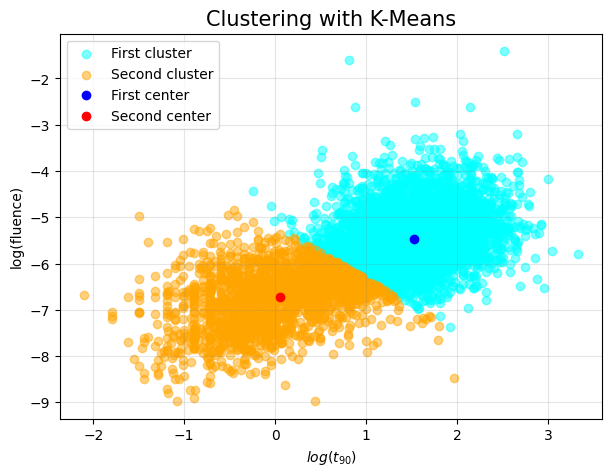

In [39]:
plt.figure(figsize=(7, 5))

plt.scatter(X[:, 0][labels_km_2d==0], X[:, 1][labels_km_2d==0], color = 'cyan', alpha = 0.5, label = 'First cluster')
plt.scatter(X[:, 0][labels_km_2d==1], X[:, 1][labels_km_2d==1], color='orange', alpha = 0.5, label = 'Second cluster')
plt.scatter(centers_km_2d[0][0], centers_km_2d[0][1], color = 'blue', label = 'First center')
plt.scatter(centers_km_2d[1][0], centers_km_2d[1][1], color = 'red', label = 'Second center')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.ylabel('log(fluence)')
plt.title('Clustering with K-Means', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

That's not so bad! Let's see what a Gaussian Mixture can find:

### Gaussian Mixture

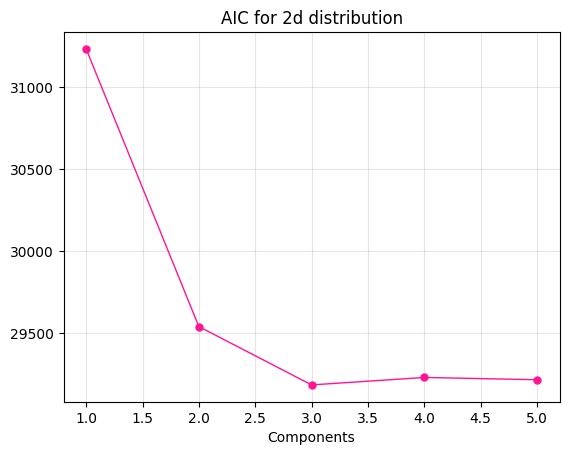

Optimal number of components according to AIC: 3
Optimal number of components through cross validation: 3


In [40]:
components = np.array([1, 2, 3, 4, 5])

# Using AIC
gm = np.array([GaussianMixture(n_components=n).fit(X) for n in components])
AIC = np.empty(len(components))

for i, n in enumerate(components):
    AIC[i] = gm[i].aic(X)

plt.plot(components, AIC, c = 'deeppink', markersize = 5, marker = 'o', linewidth = 1)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('Components')
plt.title('AIC for 2d distribution')
plt.show()

print('Optimal number of components according to AIC: %i' % components[np.argmin(AIC)]) 
best_model_2d = gm[np.argmin(AIC)]

# Using cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': components}, cv= kf) 
grid.fit(X)
n_opt_2d = grid.best_params_['n_components']
print('Optimal number of components through cross validation: %i' % n_opt_2d)

Again, the gmm finds three components. Let's plot them:

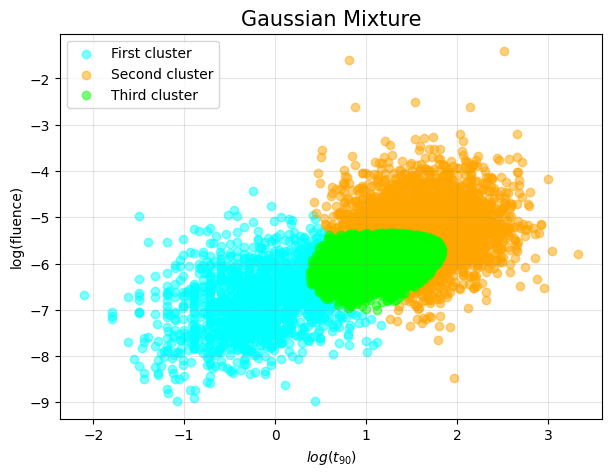

In [41]:
labels_gmm_2d = best_model_2d.predict(X)

plt.figure(figsize=(7, 5))

plt.scatter(X[:, 0][labels_gmm_2d==0], X[:, 1][labels_gmm_2d==0], color = 'cyan', alpha = 0.5, label = 'First cluster')
plt.scatter(X[:, 0][labels_gmm_2d==1], X[:, 1][labels_gmm_2d==1], color='orange', alpha = 0.5, label = 'Second cluster')
plt.scatter(X[:, 0][labels_gmm_2d==2], X[:, 1][labels_gmm_2d==2], color = 'lime', alpha = 0.5, label = 'Third cluster')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.ylabel('log(fluence)')
plt.title('Gaussian Mixture', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

This, again, doesn't make much sense, so let's force a 2-components model:

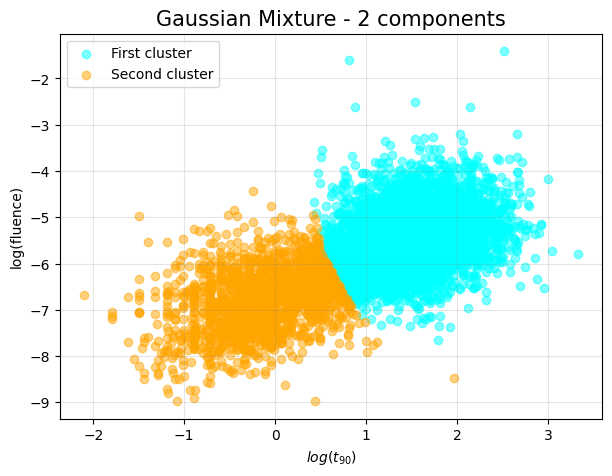

In [42]:
model_2_comps_2d = GaussianMixture(n_components=2).fit(X)
labels_gmm_2_2d = model_2_comps_2d.predict(X)

plt.figure(figsize=(7, 5))

plt.scatter(X[:, 0][labels_gmm_2_2d==0], X[:, 1][labels_gmm_2_2d==0], color = 'cyan', alpha = 0.5, label = 'First cluster')
plt.scatter(X[:, 0][labels_gmm_2_2d==1], X[:, 1][labels_gmm_2_2d==1], color='orange', alpha = 0.5, label = 'Second cluster')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.ylabel('log(fluence)')
plt.title('Gaussian Mixture - 2 components', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

This is what we would expect with short and long GRB.

Let's see what MeanShift can find:

### MeanShift clustering

In [43]:
bandwidth_ms_2d = estimate_bandwidth(X)
ms_2d = MeanShift(bandwidth=bandwidth_ms_2d)
print('Estimated bandwidth: %.2f' % bandwidth_ms_2d)
ms_2d.fit(scaled_X)

Estimated bandwidth: 0.92


MeanShift(bandwidth=0.9178084086899804)

In [44]:
labels_ms_2d = ms_2d.labels_
labels_unique_ms_2d = np.unique(ms_2d.labels_)
print(labels_unique_ms_2d)

n_clusters_ms_2d = len(labels_unique_ms_2d)
print("Number of estimated clusters : %i" % n_clusters_ms_2d)

scaled_centers_ms_2d = ms_2d.cluster_centers_

centers_ms_2d = scaler.inverse_transform(scaled_centers_ms_2d)

[0 1 2 3 4]
Number of estimated clusters : 5


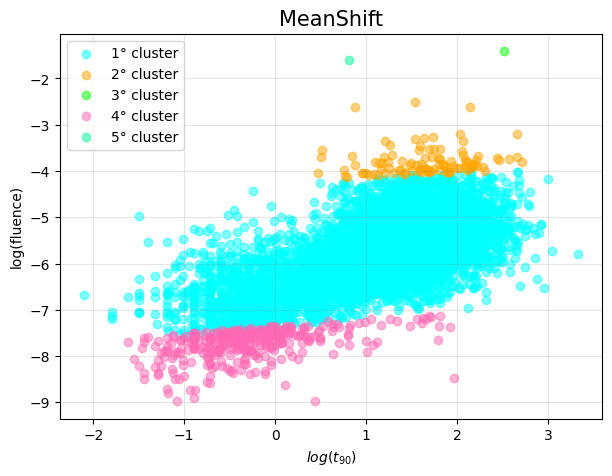

In [45]:
plt.figure(figsize=(7, 5))

colors = ['cyan', 'orange', 'lime', 'hotpink', 'mediumspringgreen']

for i in labels_unique_ms_2d:
    plt.scatter(X[:, 0][labels_ms_2d==i], X[:, 1][labels_ms_2d==i], color = colors[i], alpha = 0.5, label = '%i° cluster' % (i+1))

plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.ylabel('log(fluence)')
plt.title('MeanShift', fontsize = 15)
plt.legend(loc='upper left')
plt.show()

As expected, the result isn't good, and again, rejecting the clusters with too little points wouldn't make it much better. The $log(fluence)$ distribution is too similar to a single bell for MeanShift to correctly identify the clusters we're looking for.

## Consideration on errors

We ignored the errors up until now. Let's see if it was a good approximation or not:

C:\Users\lilit\AppData\Local\Temp\ipykernel_15488\2968494464.py:3: RuntimeWarning: invalid value encountered in log10
  ax[0].scatter(logt90, np.log10(t90_err), c = 'mediumturquoise', alpha = 0.5)
C:\Users\lilit\AppData\Local\Temp\ipykernel_15488\2968494464.py:9: RuntimeWarning: invalid value encountered in log10
  ax[1].scatter(logfluence, np.log10(fluence_err), c = 'mediumturquoise', alpha = 0.5)


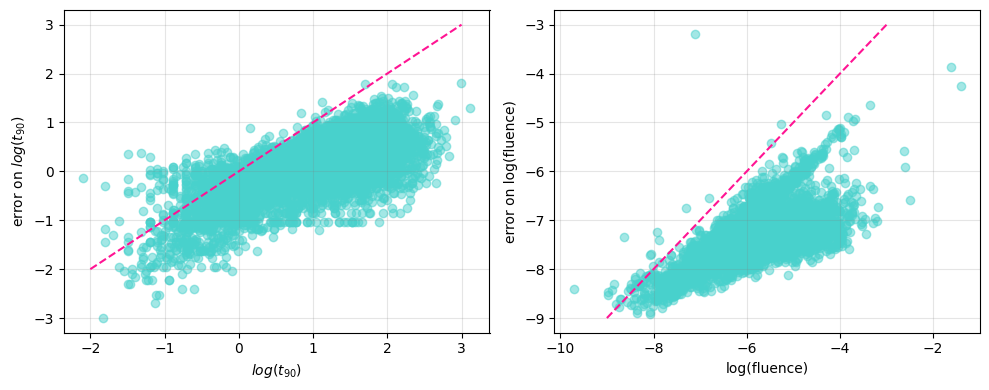

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].scatter(logt90, np.log10(t90_err), c = 'mediumturquoise', alpha = 0.5)
ax[0].plot([-2, 3], [-2, 3], c = 'deeppink', ls = '--')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('$log(t_{90})$')
ax[0].set_ylabel('error on $log(t_{90})$')

ax[1].scatter(logfluence, np.log10(fluence_err), c = 'mediumturquoise', alpha = 0.5)
ax[1].plot([-9, -3], [-9, -3], c = 'deeppink', ls = '--')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('log(fluence)')
ax[1].set_ylabel('error on log(fluence)')

plt.tight_layout()
plt.show()

About the fluence, the errors are generally smaller than the distribution of the fluence itself, so that's good.

For the duration, this is true for the long GRB, while for smaller values of $t_{90}$ it's not. 

## Redshift

Let's see what we can say about redshift. 

We'll divide short GRBs from long ones with the threshold found with the GMM model (that is closest to the 2 seconds threshold I've found).

In [47]:
threshold = 10**decision_boundary_gmm_t90
print('Threshold: %.2f' % threshold)

mask_short = np.logical_and(np.logical_and(t90_prov>0, t90_prov<threshold), z_prov>0)
mask_long = np.logical_and(np.logical_and(t90_prov>0, t90_prov>threshold), z_prov>0)

Threshold: 3.76


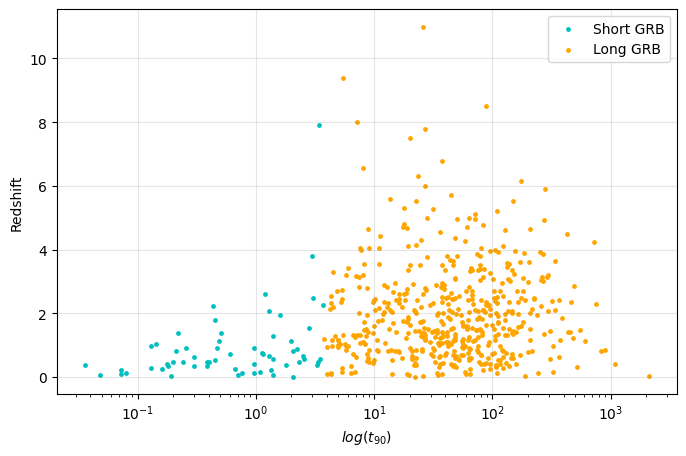

In [48]:
plt.figure(figsize = (8, 5))

plt.scatter(t90_prov[mask_short], z_prov[mask_short], color = 'c', s = 6, label = 'Short GRB')
plt.scatter(t90_prov[mask_long], z_prov[mask_long], color = 'orange', s = 6, label = 'Long GRB')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.ylabel('Redshift')
plt.semilogx()
plt.legend()
plt.show()

So, it seems that short RGBs are closer, while long RGBs can be observed at high and low redshifts.


## Position

We expect both long and short GRBs to be distributed isotropically in the sky. Let's check this assumption.

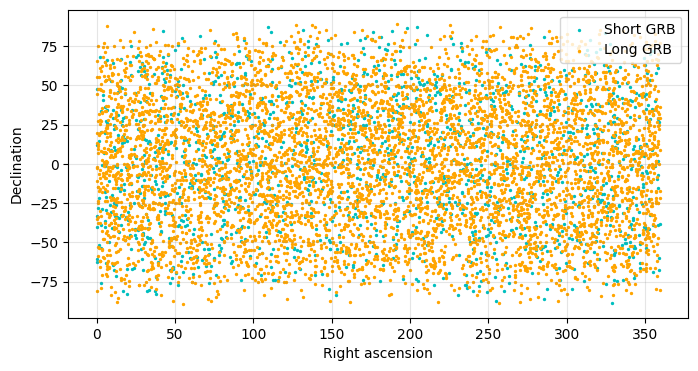

In [49]:
mask_short = np.logical_and(t90_prov>0, t90_prov<threshold, z_prov>0)
mask_long = np.logical_and(t90_prov>0, t90_prov>threshold, z_prov>0)

plt.figure(figsize = (8, 4))

plt.scatter(ra[mask_short], decl[mask_short], color = 'c', s = 2, label = 'Short GRB')
plt.scatter(ra[mask_long], decl[mask_long], color = 'orange', s = 2, label = 'Long GRB')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.legend()
plt.show()

That's what we expected!